In [ ]:
import os
import sys
import torch
import random 
import numpy as np
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter

In [ ]:
sys.path.append(os.path.abspath(os.path.join('..')))
from DeepSeparator.network import DeepSeparator

In [4]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

BATCH_SIZE = 1000

raw_eeg = np.load('./eegdenoisenet/train_input.npy')
clean_eeg = np.load('./eegdenoisenet/train_output.npy')

artifact1 = np.load('./eegdenoisenet/EOG_all_epochs.npy')
artifact2 = np.load('./eegdenoisenet/EMG_all_epochs.npy')

test_input = np.load('./eegdenoisenet/test_input.npy')
test_output = np.load('./eegdenoisenet/test_output.npy')

artifact1 = standardization(artifact1)
artifact2 = standardization(artifact2)
artifact = np.concatenate((artifact1, artifact2), axis=0)

indicator1 = np.zeros(raw_eeg.shape[0])
indicator2 = np.ones(artifact.shape[0])
indicator3 = np.zeros(clean_eeg.shape[0])
indicator = np.concatenate((indicator1, indicator2, indicator3), axis=0)

train_input = np.concatenate((raw_eeg, artifact, clean_eeg), axis=0)
train_output = np.concatenate((clean_eeg, artifact, clean_eeg), axis=0)

indicator = torch.from_numpy(indicator)
indicator = indicator.unsqueeze(1)

train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)

train_torch_dataset = Data.TensorDataset(train_input, indicator, train_output)

# Split into train and validation sets
val_ratio = 0.15
total_size = len(train_torch_dataset)
val_size = int(total_size * val_ratio)
train_size = total_size - val_size

train_subset, val_subset = random_split(train_torch_dataset, [train_size, val_size])

train_loader = Data.DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_loader = Data.DataLoader(
    dataset=val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

test_indicator = np.zeros(test_input.shape[0])
test_indicator = torch.from_numpy(test_indicator)
test_indicator = test_indicator.unsqueeze(1)

test_torch_dataset = Data.TensorDataset(test_input, test_indicator, test_output)

test_loader = Data.DataLoader(
    dataset=test_torch_dataset,
    batch_size=1,
    shuffle=False,
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepSeparator().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = nn.MSELoss(reduction='mean')

os.makedirs('checkpoints/deepseparator', exist_ok=True)
print(f"Training on device: {device}")

if os.path.exists('checkpoints/deepseparator/best_model.pth'):
    print('Loading existing model...')
    model.load_state_dict(torch.load('checkpoints/deepseparator/best_model.pth'))

Training on device: cuda


In [7]:
writer = SummaryWriter()

num_epochs = 100
best_val_loss = float('inf')
print("Starting Training...")

for epoch in range(num_epochs):
    model.train()
    
    total_train_loss_per_epoch = 0
    train_step_num = 0

    for step, (train_input, indicator, train_output) in enumerate(train_loader):
        train_step_num += 1

        # Move data to device
        indicator = indicator.float().to(device)
        train_input = train_input.float().to(device)
        train_output = train_output.float().to(device)

        optimizer.zero_grad()

        # Forward pass
        train_preds = model(train_input, indicator)

        # Calculate loss
        train_loss = criterion(train_preds, train_output)
        total_train_loss_per_epoch += train_loss.item()

        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        # Log batch loss every 50 steps
        if step % 50 == 0:
            writer.add_scalar('Loss/train_batch', train_loss.item(), epoch * len(train_loader) + step)
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{step}/{len(train_loader)}], Loss: {train_loss.item():.6f}')

    average_train_loss_per_epoch = total_train_loss_per_epoch / train_step_num
    writer.add_scalar('Loss/train', average_train_loss_per_epoch, epoch)

    # Validation
    print("Validating for epoch:", epoch + 1)
    model.eval()
    
    total_val_loss_per_epoch = 0
    val_step_num = 0

    with torch.no_grad():
        for step, (val_input, val_indicator, val_output) in enumerate(val_loader):
            val_step_num += 1

            val_indicator = val_indicator.float().to(device)
            val_input = val_input.float().to(device)
            val_output = val_output.float().to(device)

            val_preds = model(val_input, val_indicator)
            val_loss = criterion(val_preds, val_output)

            total_val_loss_per_epoch += val_loss.item()
            
            # Log validation batch loss every 20 steps
            if step % 20 == 0:
                writer.add_scalar('Loss/val_batch', val_loss.item(), epoch * len(val_loader) + step) #Aug20_01-53-09_Zero

    average_val_loss_per_epoch = total_val_loss_per_epoch / val_step_num
    writer.add_scalar('Loss/val', average_val_loss_per_epoch, epoch)

    # Update learning rate
    scheduler.step(average_val_loss_per_epoch)
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning_Rate', current_lr, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss_per_epoch:.6f}, Val Loss: {average_val_loss_per_epoch:.6f}, LR: {current_lr:.2e}")

    # Save best model
    if average_val_loss_per_epoch < best_val_loss:
        print('Saving improved model...')
        torch.save(model.state_dict(), 'checkpoints/deepseparator/best_model.pth')
        best_val_loss = average_val_loss_per_epoch

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': average_train_loss_per_epoch,
            'val_loss': average_val_loss_per_epoch,
            'best_val_loss': best_val_loss,
        }
        torch.save(checkpoint, f'checkpoints/deepseparator/checkpoint_epoch_{epoch+1}.pth')
        print(f"Checkpoint saved for epoch {epoch+1}")

    # Early stopping condition
    if current_lr < 1e-7:
        print("Learning rate too small, stopping training.")
        break

# Save final model
torch.save(model.state_dict(), 'checkpoints/deepseparator/final_model.pth')
print("Training completed!")

writer.close()

Starting Training...
Epoch [1/100], Batch [0/110], Loss: 0.785707
Epoch [1/100], Batch [50/110], Loss: 0.393060
Epoch [1/100], Batch [100/110], Loss: 0.315042
Validating for epoch: 1
Epoch [1/100], Train Loss: 0.374198, Val Loss: 0.319986, LR: 1.00e-04
Saving improved model...
Epoch [2/100], Batch [0/110], Loss: 0.282247
Epoch [2/100], Batch [50/110], Loss: 0.309365
Epoch [2/100], Batch [100/110], Loss: 0.213607
Validating for epoch: 2
Epoch [2/100], Train Loss: 0.279647, Val Loss: 0.235708, LR: 1.00e-04
Saving improved model...
Epoch [3/100], Batch [0/110], Loss: 0.193799
Epoch [3/100], Batch [50/110], Loss: 0.343423
Epoch [3/100], Batch [100/110], Loss: 0.181453
Validating for epoch: 3
Epoch [3/100], Train Loss: 0.200404, Val Loss: 0.183938, LR: 1.00e-04
Saving improved model...
Epoch [4/100], Batch [0/110], Loss: 0.168429
Epoch [4/100], Batch [50/110], Loss: 0.206749
Epoch [4/100], Batch [100/110], Loss: 0.148670
Validating for epoch: 4
Epoch [4/100], Train Loss: 0.179297, Val Loss:

In [8]:
print("\nRunning final test evaluation...")
model.eval()
total_test_loss = 0
test_step_num = 0

with torch.no_grad():
    for step, (test_input, test_indicator, test_output) in enumerate(test_loader):
        test_step_num += 1

        test_indicator = test_indicator.float().to(device)
        test_input = test_input.float().to(device)
        test_output = test_output.float().to(device)

        test_preds = model(test_input, test_indicator)
        test_loss = criterion(test_preds, test_output)

        total_test_loss += test_loss.item()

average_test_loss = total_test_loss / test_step_num
print(f'Final test loss: {average_test_loss:.6f}')


Running final test evaluation...
Final test loss: 0.077055


In [9]:
class Predictor:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.model.eval()
    
    def predict(self, noisy_eeg, task_type='denoise'):
        """
        Predict clean EEG from noisy input.
        task_type: 'denoise' (0), 'identity' (1), or 'artifact' (2)
        """
        with torch.no_grad():
            batch_size = noisy_eeg.size(0)
            
            if task_type == 'denoise':
                indicator = torch.zeros(batch_size, 1).to(self.device)
            elif task_type == 'identity':
                indicator = torch.ones(batch_size, 1).to(self.device)
            elif task_type == 'artifact':
                indicator = torch.full((batch_size, 1), 2.0).to(self.device)
            else:
                raise ValueError("task_type must be 'denoise', 'identity', or 'artifact'")
            
            pred = self.model(noisy_eeg.float(), indicator)
        return pred


In [10]:
def plot(eeg_data, title):
    """Plot EEG data with proper time axis."""
    sampling_frequency = 512  # Hz - adjust based on your data
    num_samples = len(eeg_data)
    time_duration = num_samples / sampling_frequency  # seconds
    time = np.linspace(0, time_duration, num_samples, endpoint=False)

    plt.figure(figsize=(12, 5))
    plt.plot(time, eeg_data)
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (normalized)')
    plt.grid(True)
    plt.show()

Testing on sample data...


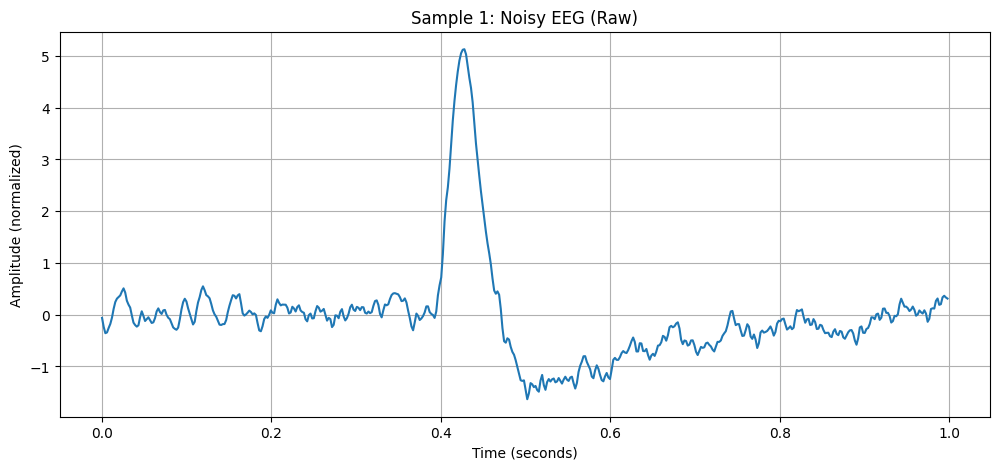

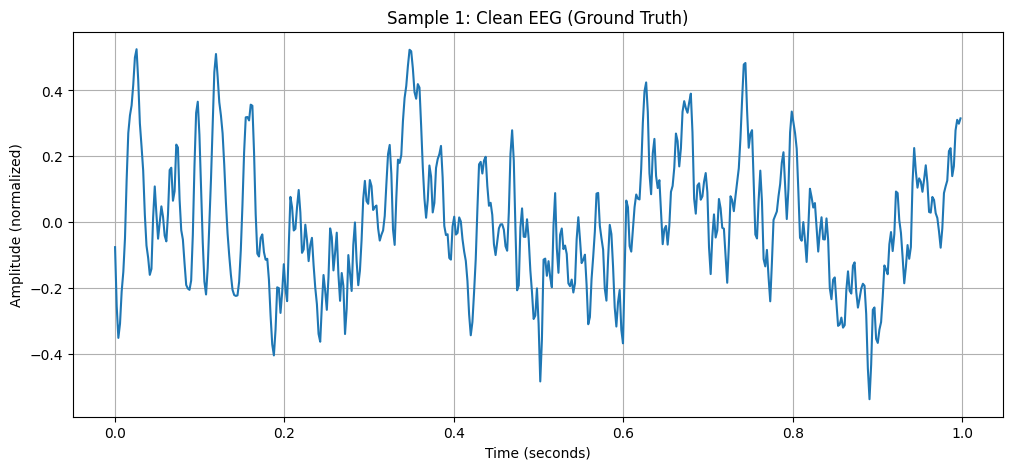

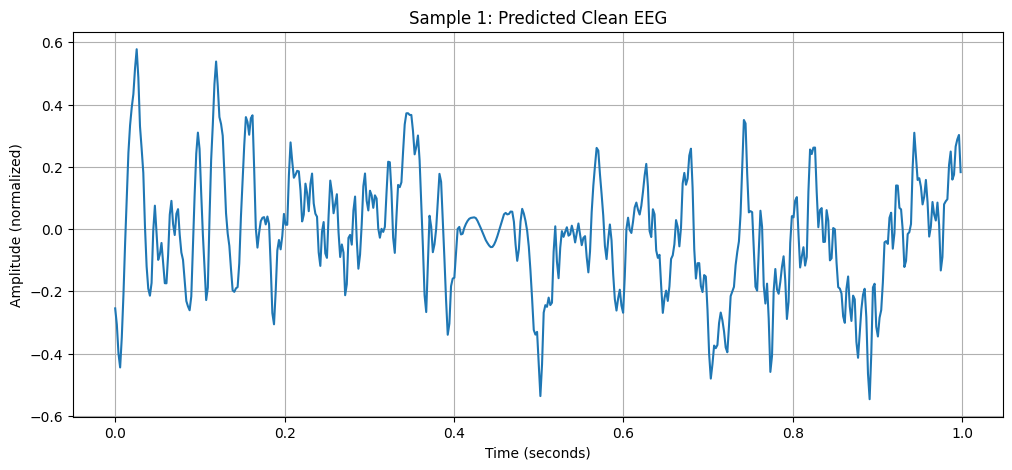

Sample 1 - MSE: 0.020138, RMSE: 0.141907
--------------------------------------------------


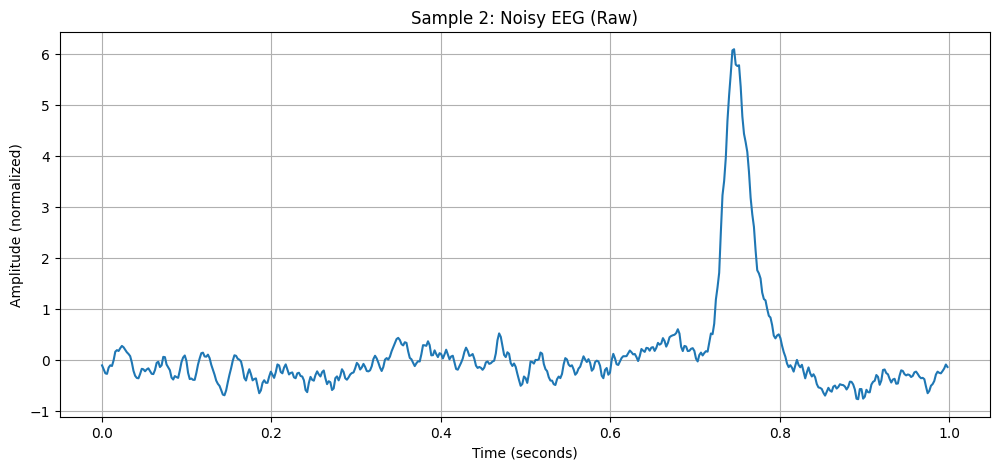

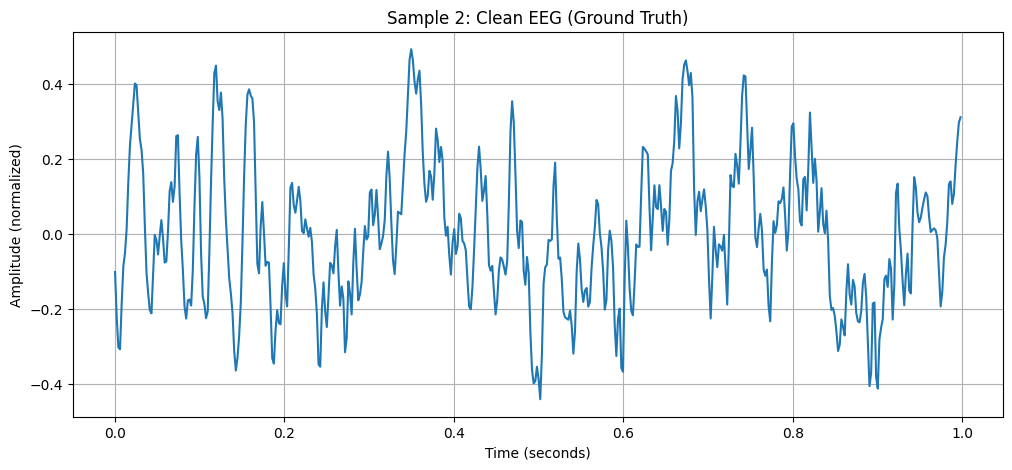

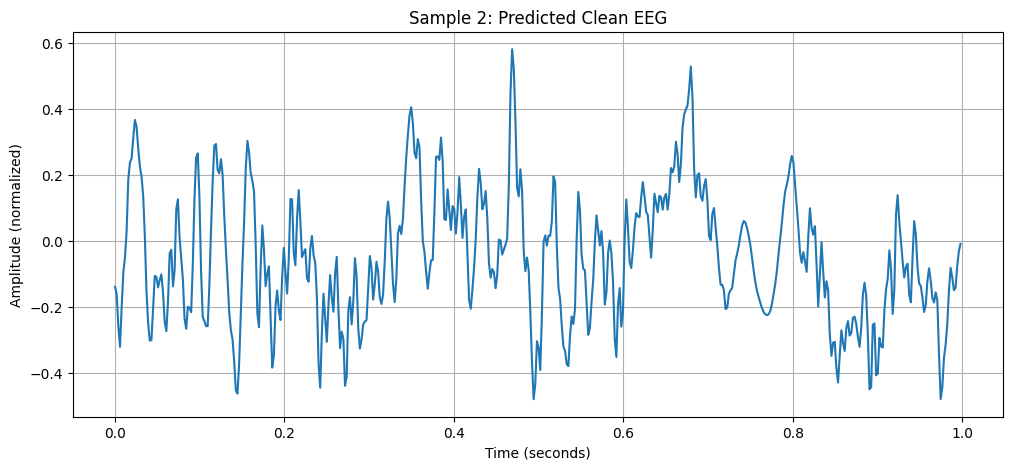

Sample 2 - MSE: 0.014957, RMSE: 0.122301
--------------------------------------------------


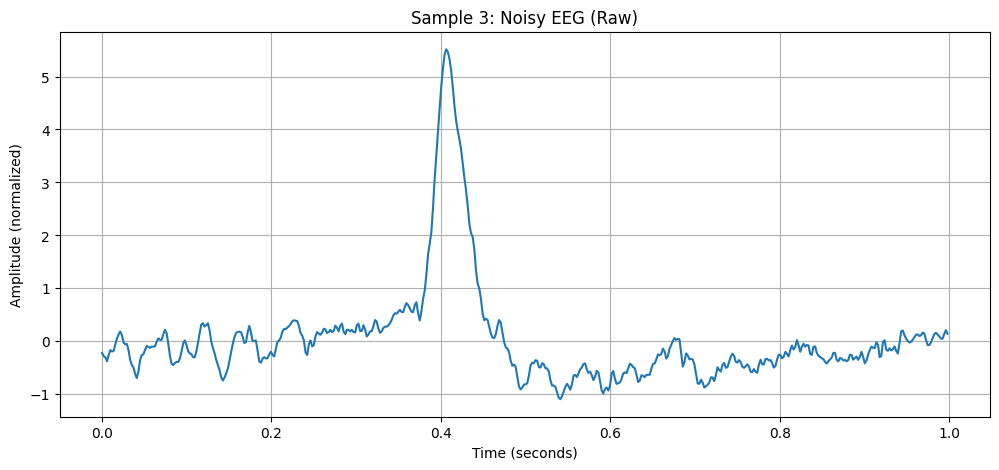

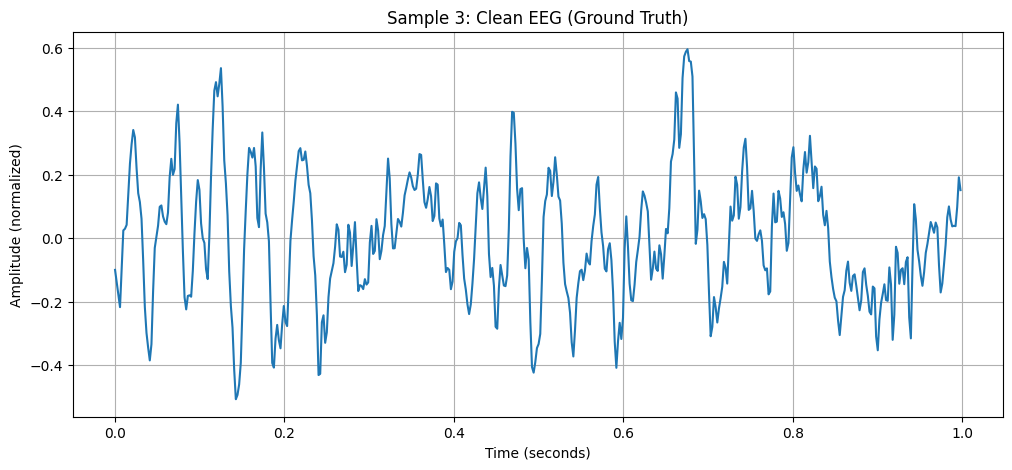

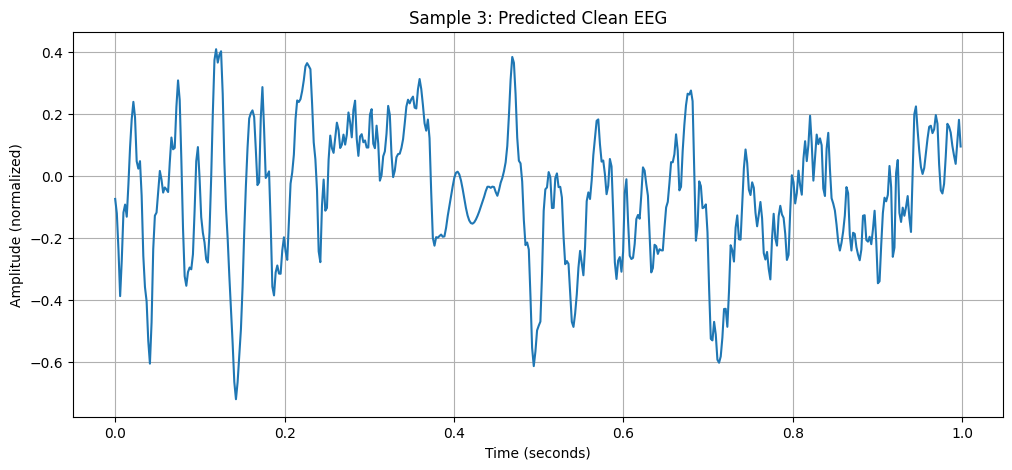

Sample 3 - MSE: 0.025055, RMSE: 0.158289
--------------------------------------------------


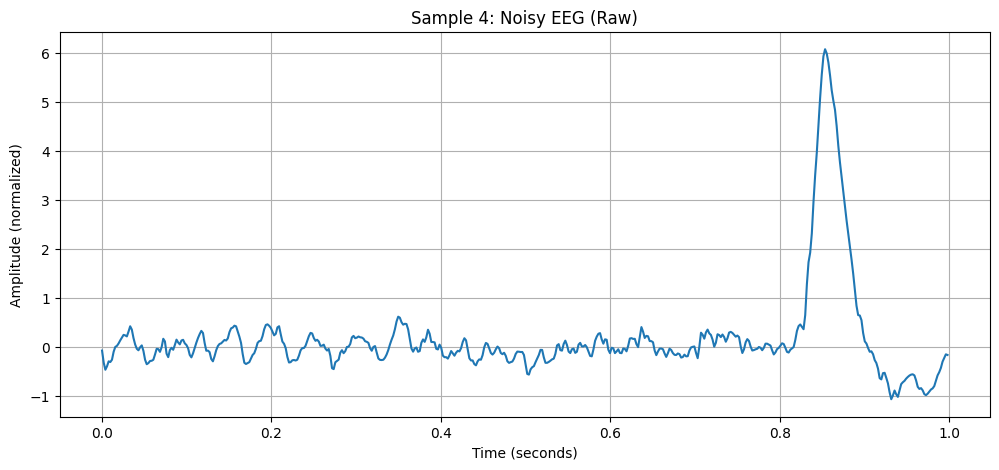

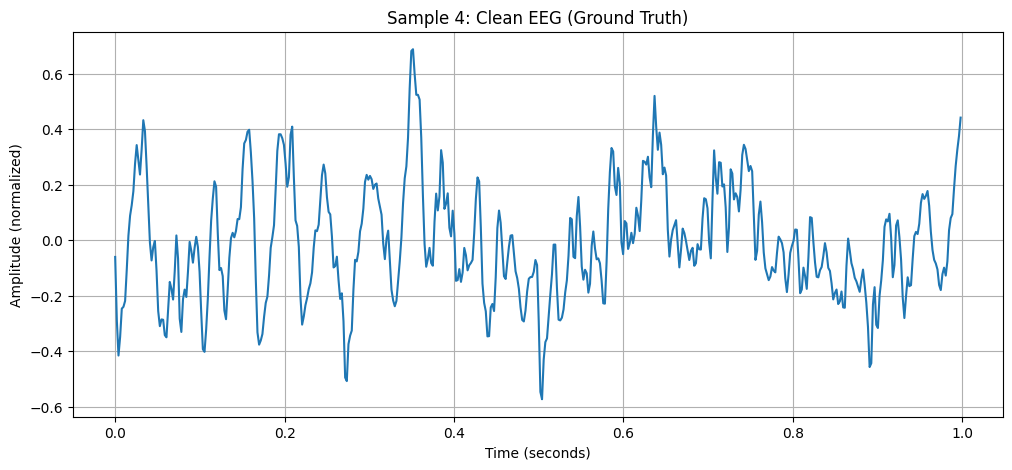

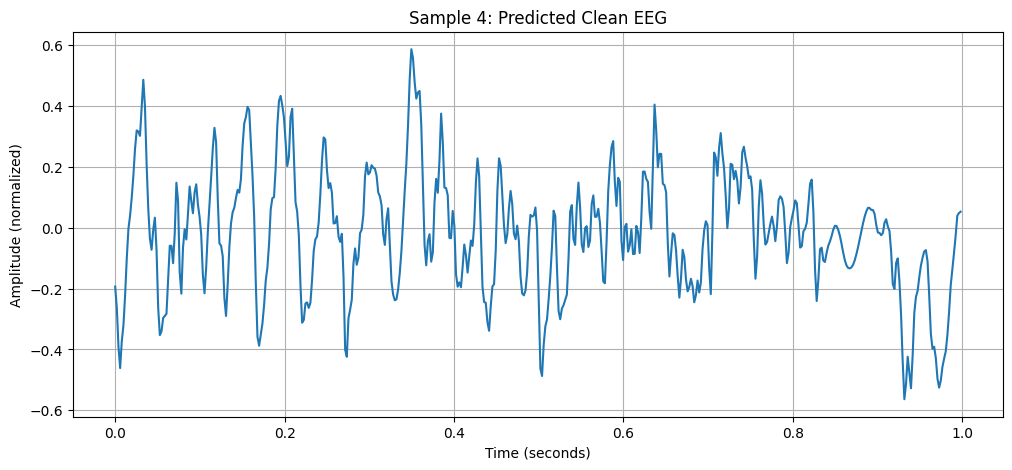

Sample 4 - MSE: 0.015794, RMSE: 0.125676
--------------------------------------------------


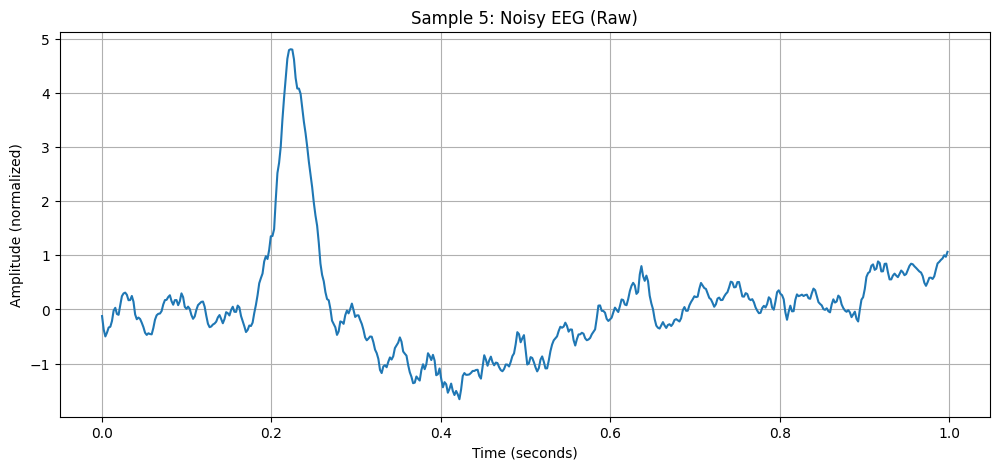

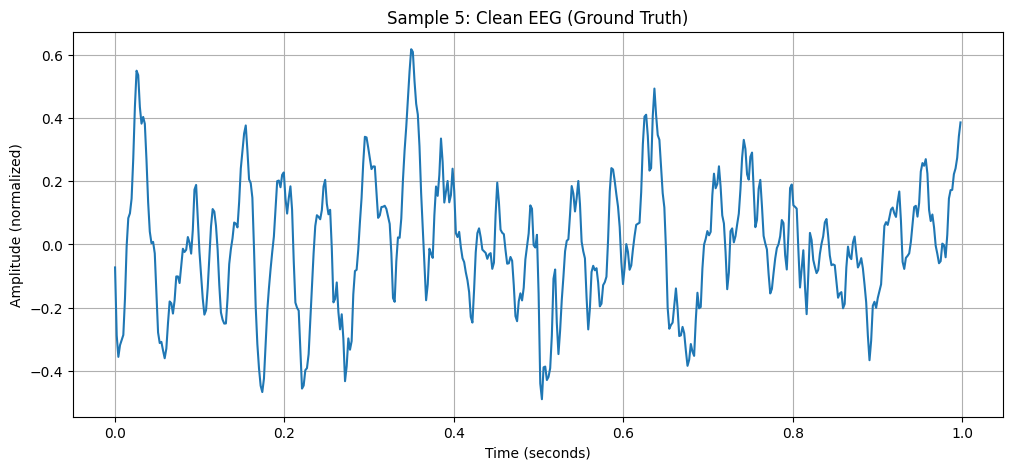

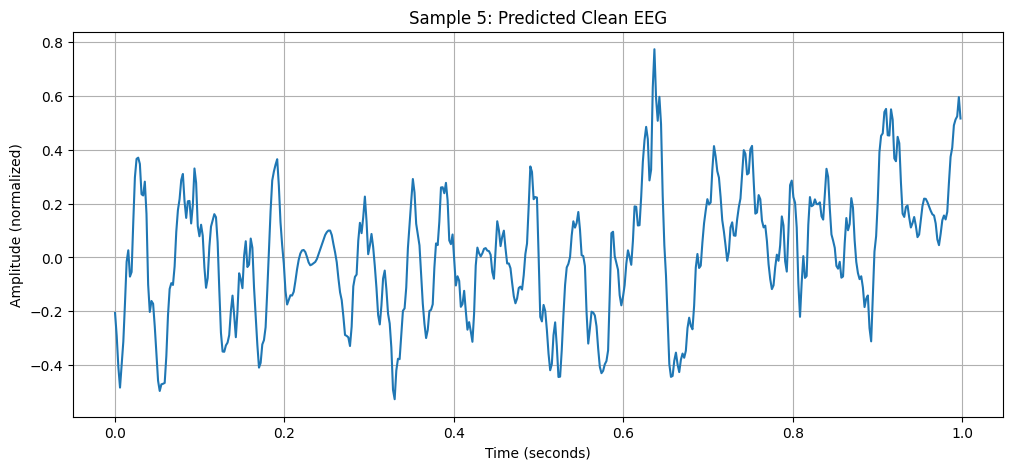

Sample 5 - MSE: 0.033089, RMSE: 0.181904
--------------------------------------------------
Testing completed!
Best validation loss achieved: 0.051504


In [11]:
predictor = Predictor(model, device)
print("Testing on sample data...")
i = 0

for step, (test_input, indicator, test_output) in enumerate(test_loader):
    # Get individual samples
    noisy_eeg = test_input.to(device)
    clean_eeg = test_output
    
    # Test denoising task
    pred_clean_eeg = predictor.predict(noisy_eeg, task_type='denoise')
    
    # Convert to numpy for plotting
    noisy_plot = noisy_eeg[0].cpu().numpy()
    clean_plot = clean_eeg[0].numpy()
    pred_plot = pred_clean_eeg[0].cpu().numpy()
    
    plot(noisy_plot, f"Sample {i+1}: Noisy EEG (Raw)")
    plot(clean_plot, f"Sample {i+1}: Clean EEG (Ground Truth)")
    plot(pred_plot, f"Sample {i+1}: Predicted Clean EEG")
    
    # Calculate and display metrics
    mse = np.mean((clean_plot - pred_plot) ** 2)
    rmse = np.sqrt(mse)
    print(f"Sample {i+1} - MSE: {mse:.6f}, RMSE: {rmse:.6f}")
    print("-" * 50)

    i += 1
    if i == 5:
        break

print("Testing completed!")
print(f"Best validation loss achieved: {best_val_loss:.6f}")